In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.math import logical_not, logical_xor
import pylab
import numpy as np
import pandas as pandas
from tensorflow.sparse import SparseTensor, to_dense, reorder
%matplotlib inline

tf.Tensor(b'It works!', shape=(), dtype=string)
You have version 2.3.0


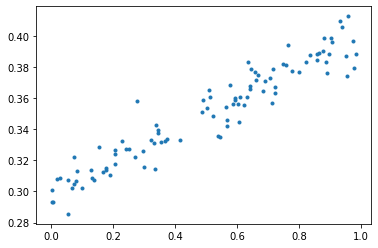

In [2]:
# PROBLEM 1
# Copied from 0_test_install.ipynb
hello = tf.constant('It works!')
print(hello)
print("You have version %s" % tf.__version__)

# create some data using numpy. y = x * 0.1 + 0.3 + noise
x_train = np.random.rand(100).astype(np.float32)
noise = np.random.normal(scale=0.01, size=len(x_train))
y_train = x_train * 0.1 + 0.3 + noise

# plot it
pylab.plot(x_train, y_train, '.')

In [3]:
# PROBLEM 2
# Using tensorflow logical function, as discussed: https://piazza.com/class/kef7vljj6ju3rv?cid=8
def xnor(x1, x2):
    '''Emulates XNOR gate, using tensorflow logical_not and logical_xor methods. Converts tensor result boolean. Returns boolean.'''
    return bool(logical_not(logical_xor(x1, x2)).numpy())

x1, x2 = tf.constant(False), tf.constant(False)
result = xnor(x1, x2)
print(result)

True


In [4]:
one = tf.constant(1)
zero = tf.constant(0)
bias = tf.constant(1)

In [5]:
# PROBLEM 3 - AND
# Inputs: x1, x2 as left-hand side of truth table, plus bias
X_train_and = tf.constant([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], "float32")
y_train_and = tf.constant([[0],[0],[0],[1]], "float32")

model_and = Sequential([
    Dense(16, input_dim=3, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_and.compile(loss='mean_squared_error', optimizer='adam', loss_weights=[20,20,-30])
model_and.fit(X_train_and, y_train_and, epochs=1000, verbose=0)

def AND(x1, x2):
    vals = [[x1,x2,bias]]
    x_input = tf.concat(axis=0, values=[vals])
    return model_and.predict(x_input)[0][0]

and_res = AND(one, one)
print(and_res)

0.89195514


In [6]:
# PROBLEM 3 - OR
# Inputs: x1, x2 as left-hand side of truth table, plus bias
X_train_or = tf.constant([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], "float32")
y_train_or = tf.constant([[0],[1],[1],[1]], "float32")

model_or = Sequential([
    Dense(16, input_dim=3, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_or.compile(loss='mean_squared_error', optimizer='adam', loss_weights=[20,20,-10])
model_or.fit(X_train_or, y_train_or, epochs=1000, verbose=0)

def OR(x1, x2):
    vals = [[x1,x2,bias]]
    x_input = tf.concat(axis=0, values=[vals])
    return model_or.predict(x_input)[0][0]

or_res = OR(zero, zero)
print(or_res)

0.13281298


In [7]:
# PROBLEM 3 - NOT
# Inputs: x1, as the left-hand side of truth table, plus bias
X_train_not = tf.constant([[0,1],[1,1]], "float32")
y_train_not = tf.constant([[1],[0]], "float32")

model_not = Sequential([
    Dense(32, input_dim=2, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_not.compile(loss='mean_squared_error', optimizer='adam', loss_weights=[20,-20])
model_not.fit(X_train_not, y_train_not, epochs=1000, verbose=0)

def NOT(x1):
    vals = [[x1,bias]]
    x_input = tf.concat(axis=0, values=[vals])
    return model_not.predict(x_input)[0][0]

not_res = NOT(zero)
print(not_res)

0.9550085


In [8]:
# PROBLEM 4
def XOR(x1, x2):
    return OR(x1, x2) - AND(x1,x2)

def XNOR(x1, x2):
    res = XOR(x1,x2).round()
    return NOT(res)

In [9]:
test = XNOR(one,one)

In [10]:
# PROBLEM 5
seed = 42
# Generate 5 tuples of integers between 0-3
def getRandInt(minval, maxval):
    return tf.random.uniform(shape=(1,), minval=minval, maxval=maxval, dtype=tf.int32, seed=seed).numpy()[0]

def getIndex():
    row = getRandInt(0,4)
    col = getRandInt(0,4)
    index = [row,col]
    return index

indices = []
values = []
for i in range(5):
    index = getIndex()
    while index in indices:
        index = getIndex()
    indices.append(index)
    
    val = getRandInt(1,11)
    values.append(val)
    
sparse_t = SparseTensor(indices=indices, values=values, dense_shape=(4,4))
dense_t = to_dense(reorder(sparse_t)).numpy()
print(dense_t)

[[ 0  0  3  0]
 [ 0  0  0 10]
 [ 0  5  0 10]
 [ 0  0  0  4]]


In [22]:
# PROBLEM 6 - NP
# Increase precision to make output more legible
# NOTE: the data in the original auto-mpg.data does not match the new auto_mpg.csv file
np.set_printoptions(precision=3)
usecols = [1,2,3,4,7,8,10]
filename = './auto_mpg.csv'
# Columns used (in order):
# Acceleration, Cylinders, Displacement, Horsepower, Model_Year, MPG, Weight
mpg = np.genfromtxt(filename, delimiter=',', usecols=usecols, skip_header=True, missing_values=0)
# Get coefficient matrix of mpg column
mpg_corrcoef = np.corrcoef(mpg.T)[5]
# Columns with highest coefficient (descending order): Weight, Cylinders, Horsepower, Displacement, Model_Year, Acceleration
# Highest positive correlation: Model_Year
# Lowest negative correlation: Weight
print(mpg_corrcoef)


[ 0.465 -0.812 -0.788 -0.797  0.717  1.    -0.852]


In [25]:
mpg = pd.read_csv(filename, usecols=usecols)
# Get coefficient matrix
mpg_corr = mpg.corr()
# Sort by absolute value of MPG column
mpg_corr.iloc[mpg_corr['MPG'].abs().argsort()][::-1]
# Columns with highest coefficient (descending order): Weight, Cylinders, Horsepower, Displacement, Model_Year, Acceleration
# Highest positive correlation: Model_Year
# Lowest negative correlation: Weight
# Confirms findings from np approach

,Acceleration,Cylinders,Displacement,Horsepower,Model_Year,MPG,Weight
MPG,0.464598,-0.811988,-0.787702,-0.797357,0.717115,1.000000,-0.851958
Weight,-0.487942,0.884401,0.889475,0.872247,-0.496371,-0.851958,1.000000
Cylinders,-0.647346,1.000000,0.951167,0.861873,-0.605270,-0.811988,0.884401
Horsepower,-0.694118,0.861873,0.913560,1.000000,-0.608498,-0.797357,0.872247
Displacement,-0.694744,0.951167,1.000000,0.913560,-0.577851,-0.787702,0.889475
Model_Year,0.484253,-0.605270,-0.577851,-0.608498,1.000000,0.717115,-0.496371
Acceleration,1.000000,-0.647346,-0.694744,-0.694118,0.484253,0.464598,-0.487942
